# Cumulative

$$
\mathcal{L} = 
$$

In [1]:
%load_ext autoreload
%autoreload 2

# Libraries

In [2]:
import pickle
from tqdm import tqdm

In [3]:
from avalanche.benchmarks.classic import PermutedMNIST
from avalanche.models import SimpleMLP
from avalanche.training import Cumulative
from avalanche.training.plugins import EvaluationPlugin
from avalanche.logging import InteractiveLogger
from avalanche.evaluation.metrics import (
    accuracy_metrics,
    bwt_metrics,
    confusion_matrix_metrics,
    forgetting_metrics,
    timing_metrics,
    cpu_usage_metrics,
    gpu_usage_metrics,
    disk_usage_metrics,
    ram_usage_metrics,
    loss_metrics,
    class_accuracy_metrics,
    accuracy_matrix_metrics
)

from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch import cuda, device

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Custom Libraries

In [4]:
import sys

sys.path.append("../base_code/")

from base_code.constants import DATASETS_PATH, SAVED_METRICS_PATH
from base_code.plugins import WeightStoragePlugin
from base_code.seed import set_seed

# Constants

In [5]:
TORCH_DEVICE = device("cuda" if cuda.is_available() else "cpu")
N_EXPERIENCES = 10
EXPERIMENT_SEED = 1234
METRICS_SUBFOLDER = "standard"
METRICS_FILENAME = f"{METRICS_SUBFOLDER}/cumulative.pkl"
set_seed(EXPERIMENT_SEED)

# Dataset and definitions

## Dataset loading

We load state-of-the-art dataset Modified NIST

In [6]:
scenario = PermutedMNIST(N_EXPERIENCES, seed=EXPERIMENT_SEED, dataset_root=DATASETS_PATH)

## Scenario creation with train test streaming

In this point, we define our scenario considering a training where in every experience of it, a new class is presented. This is, first we train with a class $a$, the following experience we train with class $b$ ($a \neq b$)

In [7]:
train_stream = scenario.train_stream
test_stream = scenario.test_stream

## Evaluation metrics definition

In [8]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True, stream=True),
    loss_metrics(minibatch=True, experience=True, stream=True),
    timing_metrics(epoch=True, epoch_running=True),
    cpu_usage_metrics(minibatch=True, experience=True, stream=True),
    gpu_usage_metrics(experience=True, stream=True, gpu_id=TORCH_DEVICE),
    disk_usage_metrics(experience=True, stream=True),
    ram_usage_metrics(experience=True, stream=True),
    class_accuracy_metrics(experience=True, stream=True),
    accuracy_matrix_metrics(),
    forgetting_metrics(experience=True, stream=True),
    bwt_metrics(experience=True, stream=True),
    confusion_matrix_metrics(stream=True, num_classes=scenario.n_classes),
    
    loggers=[InteractiveLogger()]
)

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")
/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")


## Plugin defitinitions

In [9]:
model_plugins = [WeightStoragePlugin()]

## Model, Optimizer, Loss function and Strategy definition

* `model`: Multi Layer Perceptron
* `Optimizer`: Adam
* `Loss function`: Cross Entropy
* `Strategy`: Elastic Weight Consolidation

In [10]:
model = SimpleMLP(num_classes=scenario.n_classes, input_size=28 * 28, hidden_layers=2, hidden_size=100).to(TORCH_DEVICE)
optimizer = SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
criterion = CrossEntropyLoss().to(TORCH_DEVICE)
strategy = Cumulative(
    model,
    optimizer,
    criterion,
    train_epochs=5,
    train_mb_size=128,
    plugins=model_plugins,
    evaluator=eval_plugin,
    eval_mb_size=128,
    device=TORCH_DEVICE,
)

# Training and evaluation

Revisar porque el entrenamiento se está comportando de forma rara

  0%|          | 0/10 [00:00<?, ?it/s]

-- >> Start of training phase << --
100%|██████████| 469/469 [00:03<00:00, 128.18it/s]
Epoch 0 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 113.0000
	Loss_MB/train_phase/train_stream/Task000 = 1.3063
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 3.6592
100%|██████████| 469/469 [00:03<00:00, 129.22it/s]
Epoch 1 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 110.9000
	Loss_MB/train_phase/train_stream/Task000 = 0.8962
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 3.6296
100%|██████████| 469/469 [00:03<00:00, 129.73it/s]
Epoch 2 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 116.1000
	Loss_MB/train_phase/train_stream/Task000 = 0.6136
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 3.6152
100%|██████████| 469/469 [00:03<00:00, 130.07it/s]
Epoch 3 ended.
	CPUUsage_MB/train_phase/train_

 10%|█         | 1/10 [00:26<03:57, 26.34s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 106.4059
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x148911ac0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 5648.7480
	EvalStream/Acc_Matrix = 
tensor([[0.9125, 0.1502, 0.1126, 0.1105, 0.1339, 0.0889, 0.1360, 0.0951, 0.1247,
         0.1358],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 20%|██        | 2/10 [01:12<05:03, 37.89s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 106.3572
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x148e39df0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 5648.7480
	EvalStream/Acc_Matrix = 
tensor([[0.9125, 0.1502, 0.1126, 0.1105, 0.1339, 0.0889, 0.1360, 0.0951, 0.1247,
         0.1358],
        [0.9374, 0.9292, 0.1244, 0.1029, 0.1224, 0.0827, 0.1080, 0.0939, 0.1163,
         0.1534],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 30%|███       | 3/10 [02:21<06:05, 52.23s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.4097
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x16d660640>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 5648.7480
	EvalStream/Acc_Matrix = 
tensor([[0.9125, 0.1502, 0.1126, 0.1105, 0.1339, 0.0889, 0.1360, 0.0951, 0.1247,
         0.1358],
        [0.9374, 0.9292, 0.1244, 0.1029, 0.1224, 0.0827, 0.1080, 0.0939, 0.1163,
         0.1534],
        [0.9485, 0.9436, 0.9397, 0.0947, 0.1046, 0.0911, 0.0853, 0.1381, 0.1080,
         0.1297],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 40%|████      | 4/10 [03:51<06:42, 67.07s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.5850
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x14fe57f10>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 5648.7480
	EvalStream/Acc_Matrix = 
tensor([[0.9125, 0.1502, 0.1126, 0.1105, 0.1339, 0.0889, 0.1360, 0.0951, 0.1247,
         0.1358],
        [0.9374, 0.9292, 0.1244, 0.1029, 0.1224, 0.0827, 0.1080, 0.0939, 0.1163,
         0.1534],
        [0.9485, 0.9436, 0.9397, 0.0947, 0.1046, 0.0911, 0.0853, 0.1381, 0.1080,
         0.1297],
        [0.9528, 0.9486, 0.9496, 0.9417, 0.0902, 0.0836, 0.0754, 0.1538, 0.1054,
         0.1312],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 50%|█████     | 5/10 [05:39<06:49, 81.95s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.6091
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x14fe4ee20>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 5648.7480
	EvalStream/Acc_Matrix = 
tensor([[0.9125, 0.1502, 0.1126, 0.1105, 0.1339, 0.0889, 0.1360, 0.0951, 0.1247,
         0.1358],
        [0.9374, 0.9292, 0.1244, 0.1029, 0.1224, 0.0827, 0.1080, 0.0939, 0.1163,
         0.1534],
        [0.9485, 0.9436, 0.9397, 0.0947, 0.1046, 0.0911, 0.0853, 0.1381, 0.1080,
         0.1297],
        [0.9528, 0.9486, 0.9496, 0.9417, 0.0902, 0.0836, 0.0754, 0.1538, 0.1054,
         0.1312],
        [0.9568, 0.9534, 0.9547, 0.9509, 0.9444, 0.0951, 0.0702, 0.1486, 0.1340,
         0.1457],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 60%|██████    | 6/10 [07:48<06:31, 97.89s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.6977
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x161f9dee0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 5648.7480
	EvalStream/Acc_Matrix = 
tensor([[0.9125, 0.1502, 0.1126, 0.1105, 0.1339, 0.0889, 0.1360, 0.0951, 0.1247,
         0.1358],
        [0.9374, 0.9292, 0.1244, 0.1029, 0.1224, 0.0827, 0.1080, 0.0939, 0.1163,
         0.1534],
        [0.9485, 0.9436, 0.9397, 0.0947, 0.1046, 0.0911, 0.0853, 0.1381, 0.1080,
         0.1297],
        [0.9528, 0.9486, 0.9496, 0.9417, 0.0902, 0.0836, 0.0754, 0.1538, 0.1054,
         0.1312],
        [0.9568, 0.9534, 0.9547, 0.9509, 0.9444, 0.0951, 0.0702, 0.1486, 0.1340,
         0.1457],
        [0.9589, 0.9567, 0.9567, 0.9564, 0.9514, 0.9445, 0.0975, 0.1563, 0.1173,
         0.1214],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 70%|███████   | 7/10 [10:15<05:42, 114.01s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.4971
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x16d5aacd0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 5648.7480
	EvalStream/Acc_Matrix = 
tensor([[0.9125, 0.1502, 0.1126, 0.1105, 0.1339, 0.0889, 0.1360, 0.0951, 0.1247,
         0.1358],
        [0.9374, 0.9292, 0.1244, 0.1029, 0.1224, 0.0827, 0.1080, 0.0939, 0.1163,
         0.1534],
        [0.9485, 0.9436, 0.9397, 0.0947, 0.1046, 0.0911, 0.0853, 0.1381, 0.1080,
         0.1297],
        [0.9528, 0.9486, 0.9496, 0.9417, 0.0902, 0.0836, 0.0754, 0.1538, 0.1054,
         0.1312],
        [0.9568, 0.9534, 0.9547, 0.9509, 0.9444, 0.0951, 0.0702, 0.1486, 0.1340,
         0.1457],
        [0.9589, 0.9567, 0.9567, 0.9564, 0.9514, 0.9445, 0.0975, 0.1563, 0.1173,
         0.1214],
        [0.9588, 0.9549, 0.9585, 0.9580, 0.9551, 0.9518, 0.9437, 0.1569, 0.1118,
         0.1413],
    

 80%|████████  | 8/10 [13:03<04:22, 131.13s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 104.6064
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x16da70520>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 5648.7480
	EvalStream/Acc_Matrix = 
tensor([[0.9125, 0.1502, 0.1126, 0.1105, 0.1339, 0.0889, 0.1360, 0.0951, 0.1247,
         0.1358],
        [0.9374, 0.9292, 0.1244, 0.1029, 0.1224, 0.0827, 0.1080, 0.0939, 0.1163,
         0.1534],
        [0.9485, 0.9436, 0.9397, 0.0947, 0.1046, 0.0911, 0.0853, 0.1381, 0.1080,
         0.1297],
        [0.9528, 0.9486, 0.9496, 0.9417, 0.0902, 0.0836, 0.0754, 0.1538, 0.1054,
         0.1312],
        [0.9568, 0.9534, 0.9547, 0.9509, 0.9444, 0.0951, 0.0702, 0.1486, 0.1340,
         0.1457],
        [0.9589, 0.9567, 0.9567, 0.9564, 0.9514, 0.9445, 0.0975, 0.1563, 0.1173,
         0.1214],
        [0.9588, 0.9549, 0.9585, 0.9580, 0.9551, 0.9518, 0.9437, 0.1569, 0.1118,
         0.1413],
    

 90%|█████████ | 9/10 [16:12<02:29, 149.04s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 104.6181
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x16dec0e20>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 5648.7480
	EvalStream/Acc_Matrix = 
tensor([[0.9125, 0.1502, 0.1126, 0.1105, 0.1339, 0.0889, 0.1360, 0.0951, 0.1247,
         0.1358],
        [0.9374, 0.9292, 0.1244, 0.1029, 0.1224, 0.0827, 0.1080, 0.0939, 0.1163,
         0.1534],
        [0.9485, 0.9436, 0.9397, 0.0947, 0.1046, 0.0911, 0.0853, 0.1381, 0.1080,
         0.1297],
        [0.9528, 0.9486, 0.9496, 0.9417, 0.0902, 0.0836, 0.0754, 0.1538, 0.1054,
         0.1312],
        [0.9568, 0.9534, 0.9547, 0.9509, 0.9444, 0.0951, 0.0702, 0.1486, 0.1340,
         0.1457],
        [0.9589, 0.9567, 0.9567, 0.9564, 0.9514, 0.9445, 0.0975, 0.1563, 0.1173,
         0.1214],
        [0.9588, 0.9549, 0.9585, 0.9580, 0.9551, 0.9518, 0.9437, 0.1569, 0.1118,
         0.1413],
    

100%|██████████| 10/10 [19:39<00:00, 117.93s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.5157
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x14d309a00>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 5648.7480
	EvalStream/Acc_Matrix = 
tensor([[0.9125, 0.1502, 0.1126, 0.1105, 0.1339, 0.0889, 0.1360, 0.0951, 0.1247,
         0.1358],
        [0.9374, 0.9292, 0.1244, 0.1029, 0.1224, 0.0827, 0.1080, 0.0939, 0.1163,
         0.1534],
        [0.9485, 0.9436, 0.9397, 0.0947, 0.1046, 0.0911, 0.0853, 0.1381, 0.1080,
         0.1297],
        [0.9528, 0.9486, 0.9496, 0.9417, 0.0902, 0.0836, 0.0754, 0.1538, 0.1054,
         0.1312],
        [0.9568, 0.9534, 0.9547, 0.9509, 0.9444, 0.0951, 0.0702, 0.1486, 0.1340,
         0.1457],
        [0.9589, 0.9567, 0.9567, 0.9564, 0.9514, 0.9445, 0.0975, 0.1563, 0.1173,
         0.1214],
        [0.9588, 0.9549, 0.9585, 0.9580, 0.9551, 0.9518, 0.9437, 0.1569, 0.1118,
         0.1413],
    

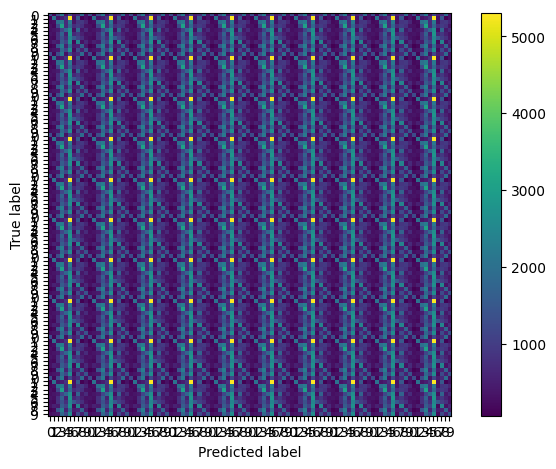

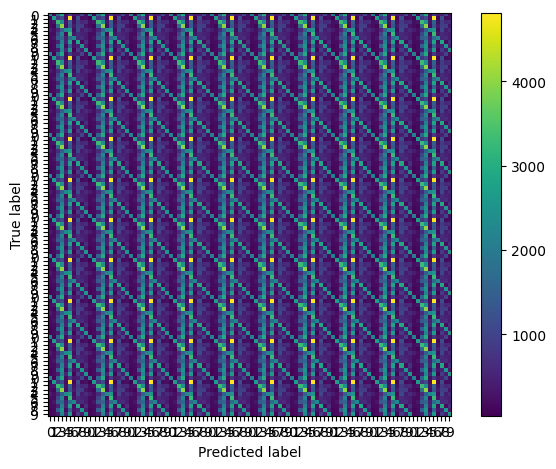

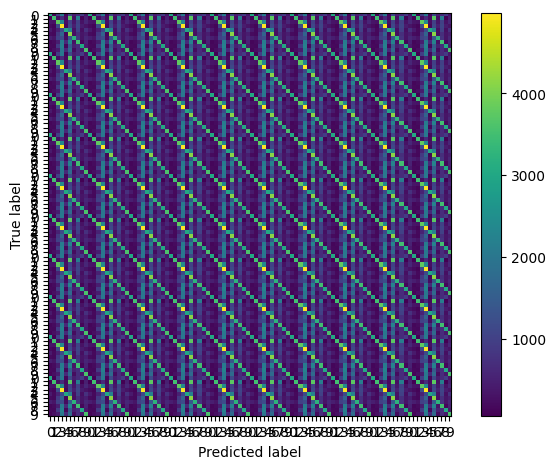

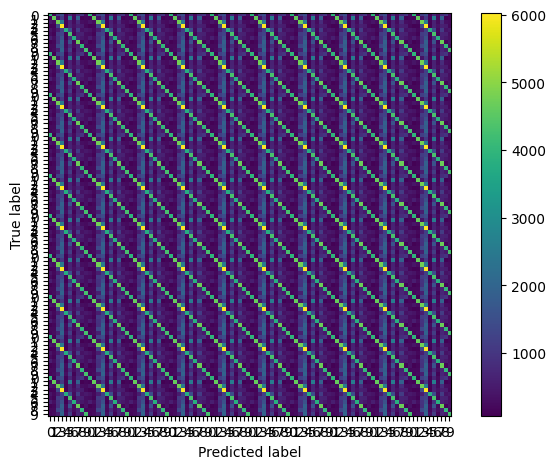

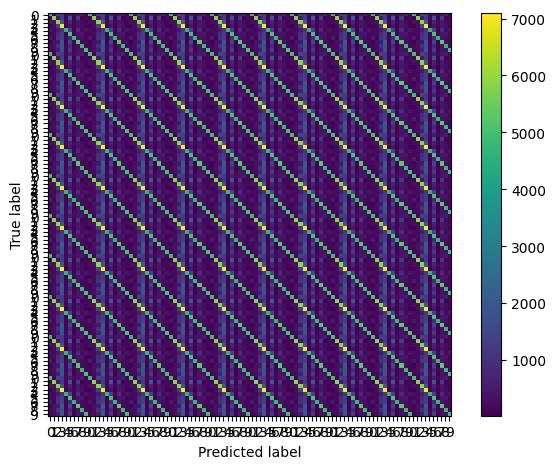

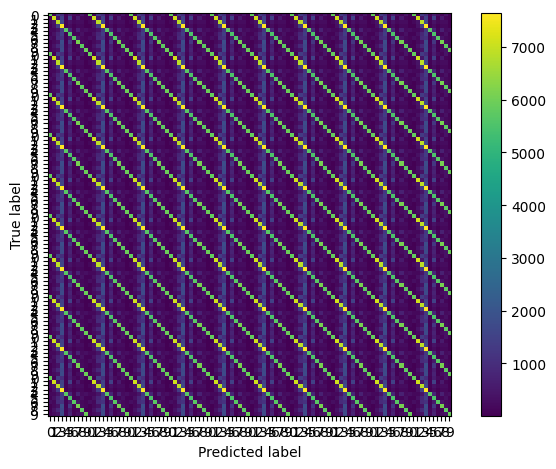

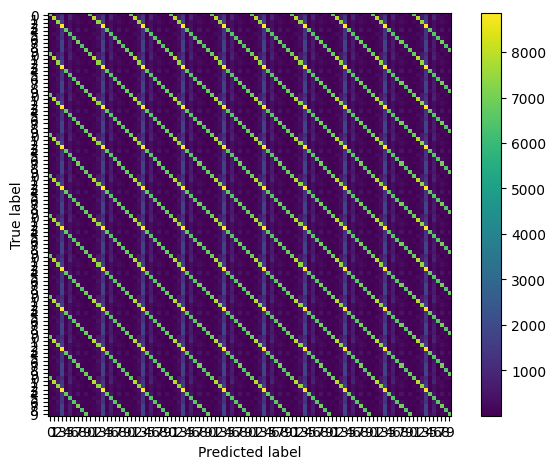

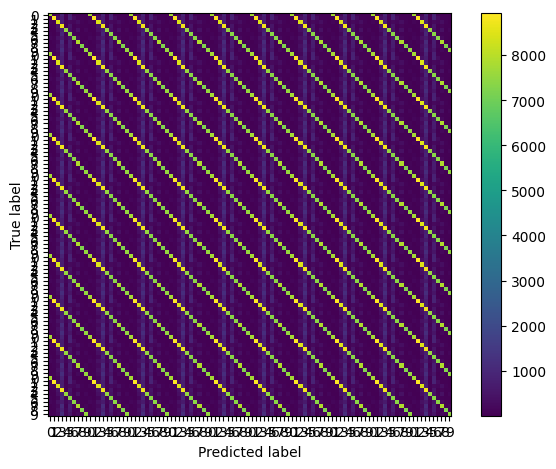

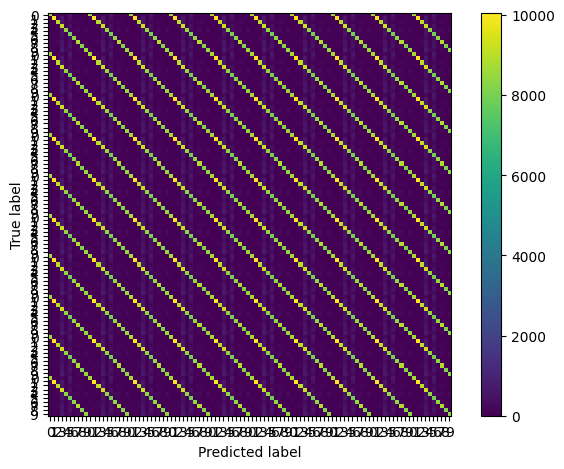

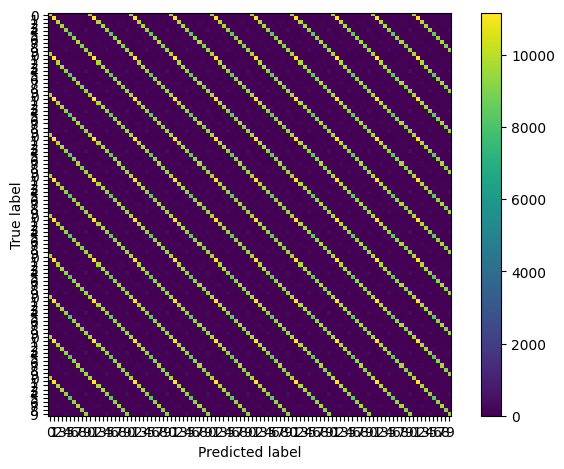

In [11]:
for experience in tqdm(train_stream):
    strategy.train(experience)
    strategy.eval(test_stream)

# Get metrics

In [12]:
accuracies: dict[int, list[float]] = dict()
forgettings: dict[int, list[float]] = dict()
bwt: dict[int, list[float]] = dict()
class_accuracies: dict[int, list[float]] = dict()
losses: dict[int, list[float]] = dict()

for i in range(N_EXPERIENCES):
    filled_i = str(i).zfill(3)
    accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    forgettings[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceForgetting/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    bwt[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceBWT/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    class_accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/{i}"
    ][1]
    losses[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Loss_Exp/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
        

accuracies["Overall"] = eval_plugin.get_all_metrics()[
    "Top1_Acc_Stream/eval_phase/test_stream/Task000"
][1]

In [13]:
train_cpu_usage = eval_plugin.get_all_metrics()["CPUUsage_MB/train_phase/train_stream/Task000"][1]
train_time_epoch = eval_plugin.get_all_metrics()["Time_Epoch/train_phase/train_stream/Task000"][1]
train_running_time = eval_plugin.get_all_metrics()["RunningTime_Epoch/train_phase/train_stream/Task000"][1]
train_loss_epoch = eval_plugin.get_all_metrics()["Loss_MB/train_phase/train_stream/Task000"][1]

In [14]:
weights = model_plugins[0].weights

# Store metrics

In [15]:
pickle.dump({
    "accuracies": accuracies,
    "forgettings": forgettings,
    "bwt": bwt,
    "class_accuracies": class_accuracies,
    "losses": losses,
    "train_cpu_usage": train_cpu_usage,
    "train_time_epoch": train_time_epoch,
    "train_running_time": train_running_time,
    "train_loss_epoch": train_loss_epoch,
    "weights": weights
}, open(SAVED_METRICS_PATH / METRICS_FILENAME, "wb"))